In [2]:
import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP

import numpy as np
import random

import matplotlib.pyplot as plt

from hgt import HGT
from heteroGNN import HeteroGNN
import graph_polluters
from tqdm import tqdm
from modules.pca import PCA

# We initialize conference node features with a single one-vector as feature:
dataset = DBLP('./data/dblp', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)


def set_seed(seed=42):
    #torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    #torch.use_deterministic_algorithms(True)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)


# Model
Here we define our model and Training Loop

In [3]:
# %%
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def init_parameters(data):
    model = HeteroGNN(data.metadata(), hidden_channels=10, out_channels=4, num_layers=2)
    #model = HGT(hidden_channels=64, out_channels=4, num_heads=2, num_layers=3, data=data)
    data, model = data.to(device), model.to(device)
    with torch.no_grad():  # Initialize lazy modules.
        out = model(data.x_dict, data.edge_index_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
    return model, optimizer

# %%
def train(data, model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['author'].train_mask
    loss = F.cross_entropy(out[mask], data['author'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data, model):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['author'][split]
        acc = (pred[mask] == data['author'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs

# Tests
We see how the model copes with the various pollution in the graph

## Baseline

In [4]:
set_seed()
dataset_copy = dataset.copy()
data_copy = dataset_copy[0]
data_copy.to(device)
model, optimizer = init_parameters(data_copy)
train_accs, val_accs, test_accs = [],[],[]
for epoch in range(1, 100):
    loss = train(data=data_copy, model=model, optimizer=optimizer)
    train_acc, val_acc, test_acc = test(data = data_copy, model=model)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
print(f'Baseline, Train: {train_acc:.4f}, '
        f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Baseline, Train: 1.0000, Val: 0.8025, Test: 0.8090


## Remove Features

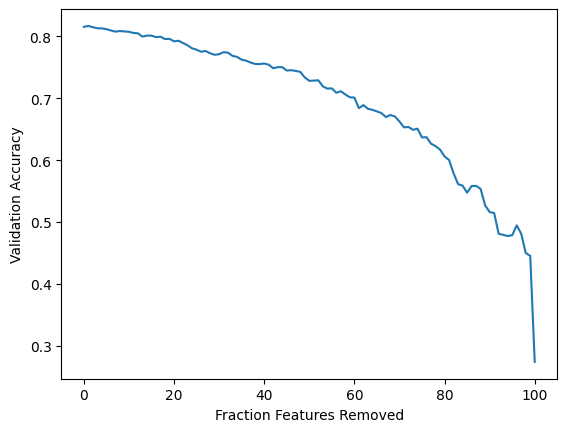

In [10]:
print_precentages = [50]
test_acc_hist = []
for percent in range(101):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    graph_polluters.remove_features(data=data_copy, probability=pollution_probability)
    data_copy.to(device)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_acc, val_acc, test_acc = test(data = data_copy, model=model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_acc)
plt.plot(range(101), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Features Removed')
plt.show()

# Remove + PCA

100%|██████████| 1/1 [00:06<00:00,  6.63s/it]

50% dirty, Train: 0.8825, Val: 0.6925, Test: 0.6973


ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

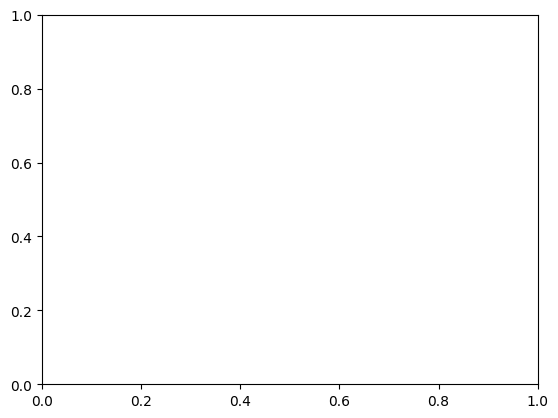

In [6]:
print_precentages = [50]
test_acc_hist = []
for percent in tqdm(range(100)):
    set_seed()
    dataset_copy = dataset.copy()
    data_copy = dataset_copy[0]
    pollution_probability = percent/100
    graph_polluters.remove_features(data=data_copy, probability=pollution_probability)
    data_copy.to(device)
    data_copy['author'].x = PCA(18).to(device).fit_transform(data_copy['author'].x)
    data_copy['term'].x = PCA(18).to(device).fit_transform(data_copy['term'].x)
    data_copy['paper'].x = PCA(18).to(device).fit_transform(data_copy['paper'].x)
    model, optimizer = init_parameters(data_copy)
    train_accs, val_accs, test_accs = [],[],[]
    for epoch in range(1, 100):
        loss = train(data=data_copy, model=model, optimizer=optimizer)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
    best_epoch = max(enumerate(val_accs),key=lambda x: x[1])[0]
    train_acc, val_acc, test_acc = train_accs[best_epoch], val_accs[best_epoch], test_accs[best_epoch]
    if percent in print_precentages:
        print(f'{percent}% dirty, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')   
    test_acc_hist.append(test_accs[best_epoch])
plt.plot(range(100), test_acc_hist)
plt.ylabel('Validation Accuracy')
plt.xlabel('Fraction Features Randomized')
plt.show()